In [2]:
!pip install deap
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools
import random

# Step 1: Load and prepare the dataset
data = pd.read_csv('dataset.csv')  # Replace with your actual file path

# Check if 'DATE' column exists and correct it if necessary
print("Columns in DataFrame:", data.columns)
if 'DATE' not in data.columns:
    # Try common alternatives
    data.rename(columns={'date': 'DATE', 'Date': 'DATE'}, inplace=True)

# Convert 'DATE' column to datetime format with the format 'Jan-06'
data['DATE'] = pd.to_datetime(data['DATE'], format='%b-%y', errors='coerce')
print(data.head())

# Check for and handle missing DATE values
if data['DATE'].isna().sum() > 0:
    print("Warning: Missing dates detected")
    data = data.dropna(subset=['DATE'])  # Drop rows where DATE could not be parsed

# Rename 'Unemployement_Rate' to 'Unemployment_Rate' if needed
if 'Unemployement_Rate' in data.columns:
    data.rename(columns={'Unemployement_Rate': 'Unemployment_Rate'}, inplace=True)

# Step 2: Add lagged features to capture temporal dependencies
data['Inflation_Rate_Lag1'] = data['Inflation_Rate'].shift(1)
data['Unemployment_Rate_Lag1'] = data['Unemployment_Rate'].shift(1)
# Add other relevant lags as needed

# Drop rows with NaN values created by shifting
data.dropna(inplace=True)

# Step 3: Split data into training and test sets based on time
train_data = data[data['DATE'] < '2017-01-01']
test_data = data[data['DATE'] >= '2017-01-01']

X_train = train_data.drop(['Inflation_Rate', 'DATE'], axis=1)
y_train = train_data['Inflation_Rate']
X_test = test_data.drop(['Inflation_Rate', 'DATE'], axis=1)
y_test = test_data['Inflation_Rate']

# Step 4: Set up GA for parameter tuning with bounds based on the paper’s suggestions
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# Define the parameter bounds based on the paper's suggestions
param_bounds = {
    'max_depth': (8, 10),             # Based on paper's values
    'learning_rate': (0.01, 0.1),     # Narrow range as suggested in paper
    'n_estimators': (100, 300),
    'subsample': (0.7, 1.0),
    'colsample_bytree': (0.7, 1.0),
    'min_child_weight': (3, 4),       # Based on 3.751 in paper
    'lambda': (0.5, 1.0)              # Regularization term based on paper's values
}

# Initialize GA individuals within valid ranges
toolbox.register("individual", tools.initIterate, creator.Individual,
                 lambda: [
                     random.randint(param_bounds['max_depth'][0], param_bounds['max_depth'][1]),
                     random.uniform(param_bounds['learning_rate'][0], param_bounds['learning_rate'][1]),
                     random.randint(param_bounds['n_estimators'][0], param_bounds['n_estimators'][1]),
                     random.uniform(param_bounds['subsample'][0], param_bounds['subsample'][1]),
                     random.uniform(param_bounds['colsample_bytree'][0], param_bounds['colsample_bytree'][1]),
                     random.uniform(param_bounds['min_child_weight'][0], param_bounds['min_child_weight'][1]),
                     random.uniform(param_bounds['lambda'][0], param_bounds['lambda'][1])
                 ])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Function to enforce parameter bounds
def enforce_bounds(individual):
    individual[0] = int(max(param_bounds['max_depth'][0], min(individual[0], param_bounds['max_depth'][1])))
    individual[1] = max(param_bounds['learning_rate'][0], min(individual[1], param_bounds['learning_rate'][1]))
    individual[2] = int(max(param_bounds['n_estimators'][0], min(individual[2], param_bounds['n_estimators'][1])))
    individual[3] = max(param_bounds['subsample'][0], min(individual[3], param_bounds['subsample'][1]))
    individual[4] = max(param_bounds['colsample_bytree'][0], min(individual[4], param_bounds['colsample_bytree'][1]))
    individual[5] = max(param_bounds['min_child_weight'][0], min(individual[5], param_bounds['min_child_weight'][1]))
    individual[6] = max(param_bounds['lambda'][0], min(individual[6], param_bounds['lambda'][1]))
    return individual

# Evaluation function using cross-validation
def evaluate(individual):
    params = {
        'max_depth': int(individual[0]),
        'learning_rate': individual[1],
        'n_estimators': int(individual[2]),
        'subsample': individual[3],
        'colsample_bytree': individual[4],
        'min_child_weight': individual[5],
        'reg_lambda': individual[6]
    }
    model = XGBRegressor(**params, objective="reg:squarederror", random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    rmse = -scores.mean()
    return (rmse,)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Step 5: Run the Genetic Algorithm
population = toolbox.population(n=20)
n_generations = 10

for gen in range(n_generations):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            enforce_bounds(mutant)
            del mutant.fitness.values

    invalid_ind = [enforce_bounds(ind) for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    population[:] = offspring
    best_individual = tools.selBest(population, 1)[0]
    print(f"Generation {gen + 1}: Best RMSE = {best_individual.fitness.values[0]}")

# Extract the best parameters from GA tuning
best_params = {
    'max_depth': int(best_individual[0]),
    'learning_rate': best_individual[1],
    'n_estimators': int(best_individual[2]),
    'subsample': best_individual[3],
    'colsample_bytree': best_individual[4],
    'min_child_weight': best_individual[5],
    'reg_lambda': best_individual[6]
}
print("Best Parameters:", best_params)

# Step 6: Train the final model with the best parameters and evaluate on test data
final_model = XGBRegressor(**best_params, objective="reg:squarederror", random_state=42)
final_model.fit(X_train, y_train)
predictions = final_model.predict(X_test)

# Calculate and print the RMSE on the test data
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Final RMSE on Test Data:", rmse)


Columns in DataFrame: Index(['DATE', 'M1', 'M2', 'Bank_Rate', 'Stock_Index', 'Unemployement_Rate',
       'Federal_Reserve_Rate', 'Inflation_Rate'],
      dtype='object')
        DATE      M1      M2  Bank_Rate  Stock_Index  Unemployement_Rate  \
0 2006-01-01  1379.5  6713.2       7.50      8250.92                 4.7   
1 2006-02-01  1378.4  6730.6       7.50      8408.73                 4.8   
2 2006-03-01  1383.2  6803.4       7.75      8482.77                 4.7   
3 2006-04-01  1381.4  6867.0       7.75      8773.99                 4.7   
4 2006-05-01  1387.2  6805.4       8.00      8406.23                 4.6   

   Federal_Reserve_Rate  Inflation_Rate  
0                100.00        3.940136  
1                100.24        3.573632  
2                100.53        3.360805  
3                100.03        3.550069  
4                 97.85        3.900216  
Generation 1: Best RMSE = 0.7117607467993702
Generation 2: Best RMSE = 0.7117607467993702
Generation 3: Best RMSE = 0.71

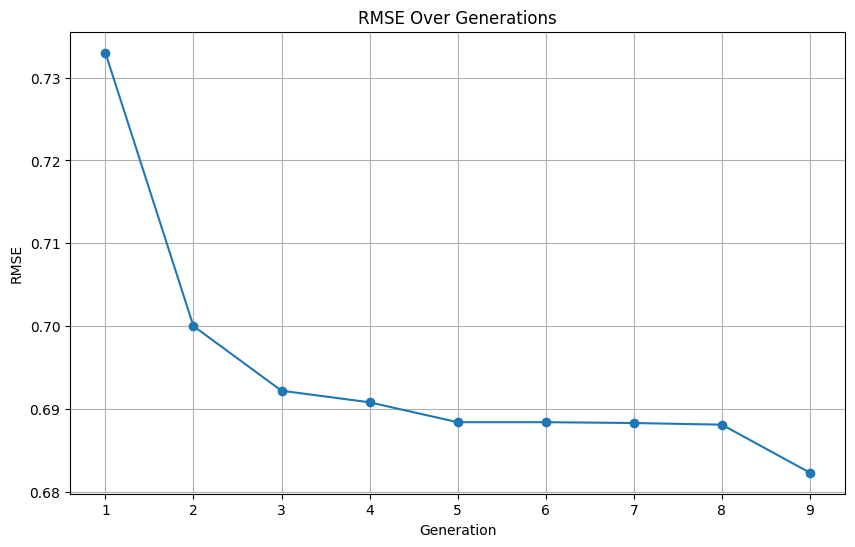

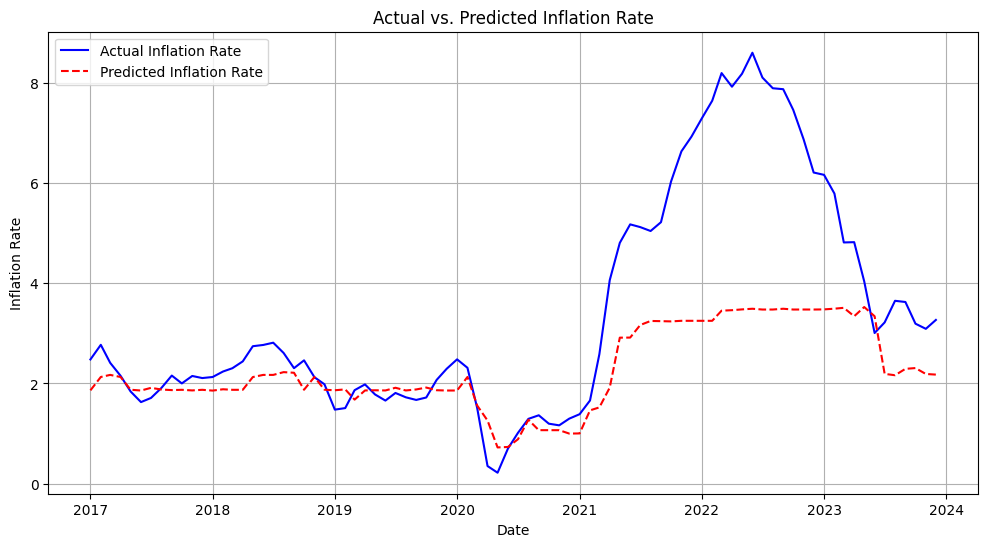

<Figure size 1000x800 with 0 Axes>

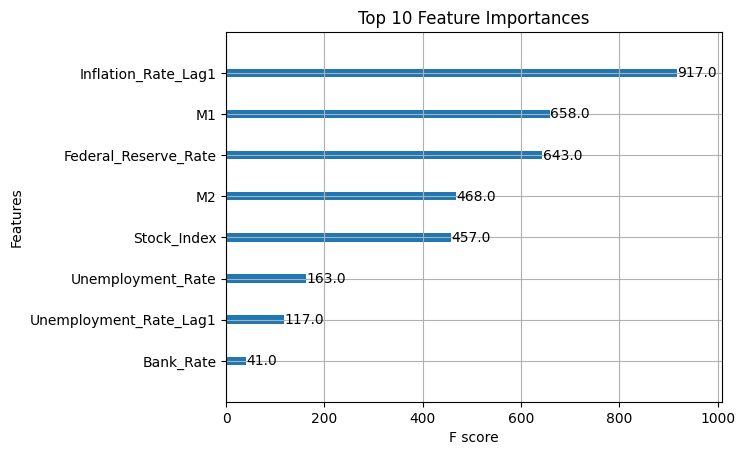

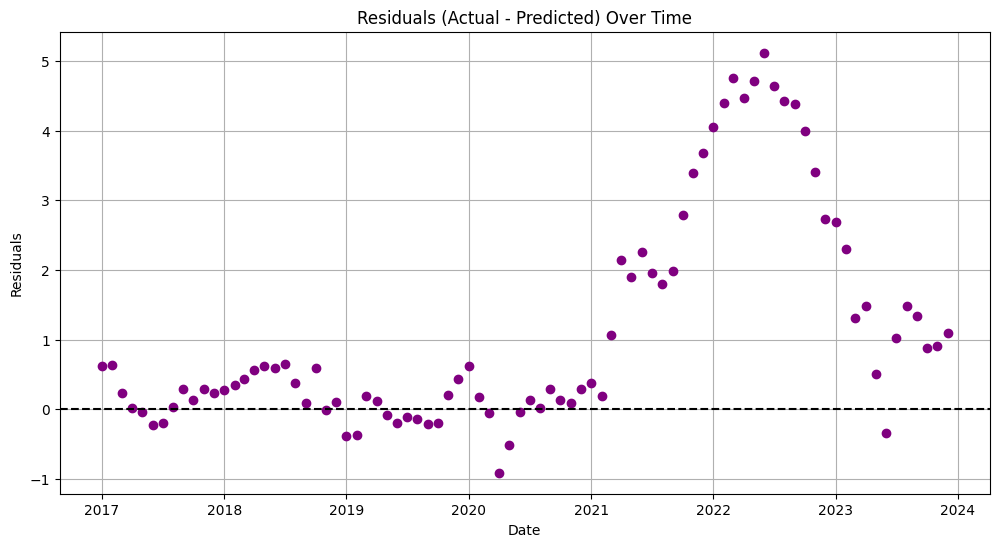

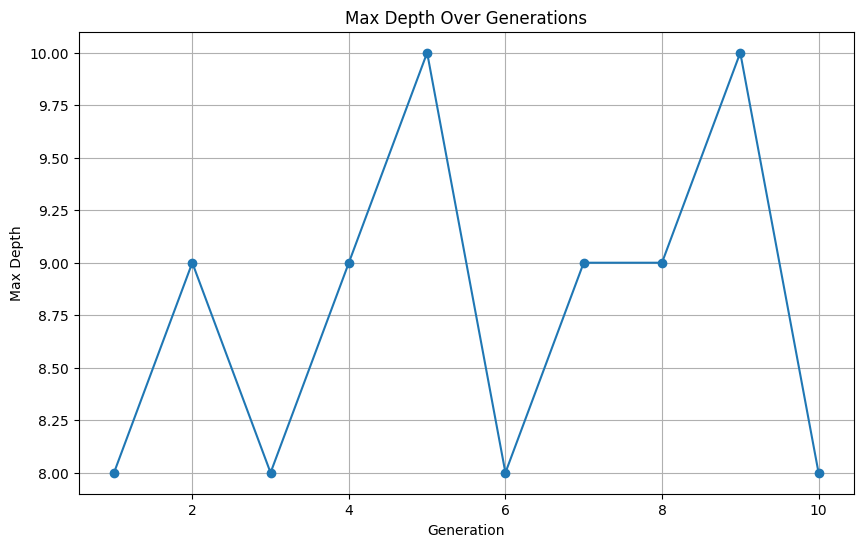

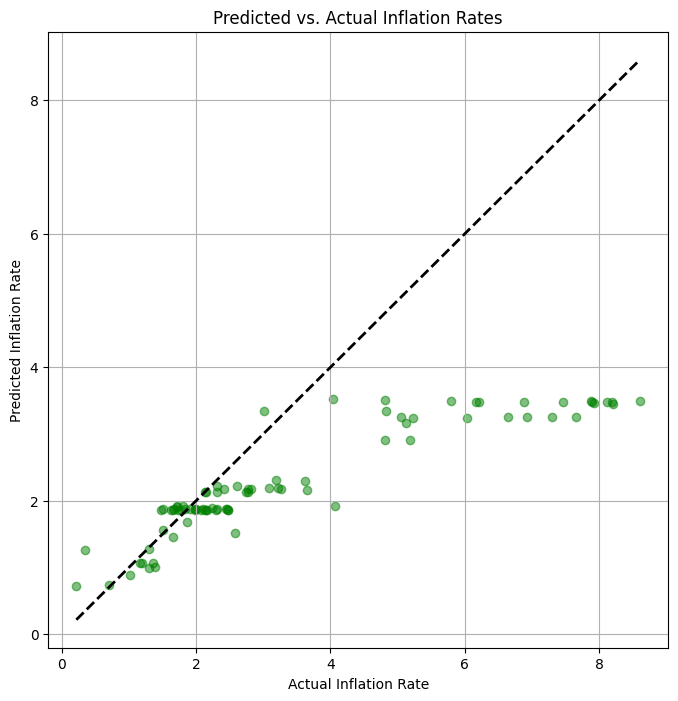

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Assuming these variables exist based on the training process:
# - `rmse_per_generation`: List of RMSE values for each GA generation
# - `predictions`: Model predictions on the test set
# - `y_test`: Actual inflation rates on the test set
# - `test_data['DATE']`: Dates corresponding to the test set
# - `final_model`: Trained XGBoost model

# Example data (replace with actual values)
rmse_per_generation = [0.7330, 0.7000, 0.6922, 0.6908, 0.6884, 0.6884, 0.6883, 0.6881, 0.6823]
max_depth_over_generations = [8, 9, 8, 9, 10, 8, 9, 9, 10, 8]  # Example, replace with actual tracked values

# 1. RMSE Over Generations
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rmse_per_generation) + 1), rmse_per_generation, marker='o', linestyle='-')
plt.title('RMSE Over Generations')
plt.xlabel('Generation')
plt.ylabel('RMSE')
plt.grid()
plt.show()

# 2. Actual vs. Predicted Inflation Rate (Time-Series Comparison)
plt.figure(figsize=(12, 6))
plt.plot(test_data['DATE'], y_test, label='Actual Inflation Rate', color='blue')
plt.plot(test_data['DATE'], predictions, label='Predicted Inflation Rate', color='red', linestyle='--')
plt.title('Actual vs. Predicted Inflation Rate')
plt.xlabel('Date')
plt.ylabel('Inflation Rate')
plt.legend()
plt.grid()
plt.show()

# 3. Feature Importance
plt.figure(figsize=(10, 8))
plot_importance(final_model, importance_type='weight', max_num_features=10)
plt.title('Top 10 Feature Importances')
plt.show()

# 4. Residual Analysis
residuals = y_test - predictions

plt.figure(figsize=(12, 6))
plt.plot(test_data['DATE'], residuals, marker='o', linestyle='', color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals (Actual - Predicted) Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid()
plt.show()

# 5. Hyperparameter Evolution Over Generations (Example with max_depth)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(max_depth_over_generations) + 1), max_depth_over_generations, marker='o', linestyle='-')
plt.title('Max Depth Over Generations')
plt.xlabel('Generation')
plt.ylabel('Max Depth')
plt.grid()
plt.show()

# 6. Predicted vs. Actual Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, predictions, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Predicted vs. Actual Inflation Rates')
plt.xlabel('Actual Inflation Rate')
plt.ylabel('Predicted Inflation Rate')
plt.grid()
plt.show()
